The code is taken from here:

https://keras.io/examples/nlp/lstm_seq2seq/

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/


# CHOLLET - BASE MODEL - 1024 - rmsprop

In [1]:
import numpy as np
import pandas as pd
import os
from numpy import save
from numpy import load
import matplotlib.pyplot as plt
from numpy import argmax

from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Concatenate
from keras.layers import LayerNormalization

from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

from keras.layers import Attention as AttentionLayer

2022-09-12 15:52:03.395001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 15:52:03.455542: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-12 15:52:03.472061: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-12 15:52:03.729652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

# Load data

In [2]:
#audio_features = pd.DataFrame(load('features/audio_wav2vec_features_0-14500_artificial_onlygood_converted2array.npy', allow_pickle=True))
#video_features = pd.DataFrame(load('features/video_clip_features_0-14500_artificial_onlygood_converted2array.npy', allow_pickle=True))
audio_features = pd.DataFrame(load('features/audio_features_without_phone.npy', allow_pickle=True))
video_features = pd.DataFrame(load('features/video_features_without_phone.npy', allow_pickle=True))

# audio features one-hot
audio_features_onehot = keras.utils.to_categorical(audio_features, num_classes=None, dtype='float32')

# video features one-hot
def normalize(x):
    return (x.astype(float) - video_features.min().min().astype(float)) / (video_features.max().max().astype(float) - video_features.min().min().astype(float))

def de_normalize(x):
    return (x * (video_features.max().max().astype(float) - video_features.min().min().astype(float)) + video_features.min().min().astype(float)).astype(int)

video_features_norm = normalize(video_features)
video_features_norm_100 = video_features_norm * 100
video_features_norm_100 = video_features_norm_100.round()
video_features_onehot = keras.utils.to_categorical(video_features_norm_100, num_classes=None, dtype='float32')


In [3]:
audio_features_onehot.shape

(13050, 150, 27)

In [4]:
video_features_onehot.shape


(13050, 512, 101)

# Split train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(video_features_onehot, audio_features_onehot, test_size=0.2, random_state=True)


# Create decoder_input_data, decoder_target_data, encoder_input_data

In [6]:
encoder_input_data = X_train
decoder_input_data = y_train
decoder_target_data = np.zeros(decoder_input_data.shape)
for a in range(decoder_input_data.shape[0]):
    for i in range(decoder_input_data.shape[1]-1):
        decoder_target_data[a][i]=decoder_input_data[a][i+1]
    decoder_target_data[a][decoder_input_data.shape[1]-1] = decoder_input_data[a][decoder_input_data.shape[1]-1]
    


In [7]:
encoder_input_data_test = X_test
decoder_input_data_test = y_test

decoder_target_data_test = np.zeros(y_test.shape)
for a in range(y_test.shape[0]):
    for i in range(y_test.shape[1]-1):
        decoder_target_data_test[a][i]=y_test[a][i+1]
    decoder_target_data_test[a][y_test.shape[1]-1] = y_test[a][y_test.shape[1]-1]

In [8]:
# lengths of vectors
num_encoder_tokens = encoder_input_data.shape[2]
num_decoder_tokens = decoder_input_data.shape[2]
target_max_length = decoder_input_data.shape[1]

# Set up the model

In [9]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 1024  # Latent dimensionality of the encoding space.


In [10]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


2022-09-12 15:52:06.187206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:52:06.189771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:52:06.189851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 15:52:06.190116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 101)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 27)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 1024),       4612096     ['input_1[0][0]']                
                                 (None, 1024),                                                    
                                 (None, 1024)]                                                    
                                                                                              

In [12]:
import tensorflow as tf
import tensorflow_addons as tfa
f1 = tfa.metrics.F1Score(num_classes=2, average=None)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None), keras.metrics.Recall()
]
)


In [13]:
results = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

Epoch 1/100


2022-09-12 15:52:09.749516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


  1/131 [..............................] - ETA: 4:03 - loss: 3.2973 - accuracy: 0.0042 - precision: 0.0000e+00 - recall: 0.0000e+00

2022-09-12 15:52:10.126650: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


131/131 [==============================] - 16s 105ms/step - loss: 0.8108 - accuracy: 0.8212 - precision: 0.8644 - recall: 0.7690 - val_loss: 0.5917 - val_accuracy: 0.8378 - val_precision: 0.9033 - val_recall: 0.7668
Epoch 2/100
131/131 [==============================] - 13s 102ms/step - loss: 0.5288 - accuracy: 0.8444 - precision: 0.8954 - recall: 0.7930 - val_loss: 0.4214 - val_accuracy: 0.8642 - val_precision: 0.9038 - val_recall: 0.8151
Epoch 3/100
131/131 [==============================] - 13s 100ms/step - loss: 0.3594 - accuracy: 0.8752 - precision: 0.9057 - recall: 0.8416 - val_loss: 0.2947 - val_accuracy: 0.8909 - val_precision: 0.9141 - val_recall: 0.8655
Epoch 4/100
131/131 [==============================] - 13s 102ms/step - loss: 0.2534 - accuracy: 0.9039 - precision: 0.9233 - recall: 0.8855 - val_loss: 0.2281 - val_accuracy: 0.9118 - val_precision: 0.9293 - val_recall: 0.8963
Epoch 5/100
131/131 [==============================] - 13s 101ms/step - loss: 0.2148 - accuracy: 0.9

Epoch 37/100
131/131 [==============================] - 14s 103ms/step - loss: 0.0600 - accuracy: 0.9781 - precision: 0.9787 - recall: 0.9774 - val_loss: 0.0667 - val_accuracy: 0.9757 - val_precision: 0.9766 - val_recall: 0.9748
Epoch 38/100
131/131 [==============================] - 13s 103ms/step - loss: 0.0600 - accuracy: 0.9781 - precision: 0.9788 - recall: 0.9775 - val_loss: 0.0661 - val_accuracy: 0.9757 - val_precision: 0.9765 - val_recall: 0.9750
Epoch 39/100
131/131 [==============================] - 14s 104ms/step - loss: 0.1251 - accuracy: 0.9584 - precision: 0.9608 - recall: 0.9564 - val_loss: 0.0856 - val_accuracy: 0.9682 - val_precision: 0.9699 - val_recall: 0.9667
Epoch 40/100
131/131 [==============================] - 14s 103ms/step - loss: 0.0663 - accuracy: 0.9762 - precision: 0.9771 - recall: 0.9753 - val_loss: 0.0656 - val_accuracy: 0.9765 - val_precision: 0.9773 - val_recall: 0.9757
Epoch 41/100
131/131 [==============================] - 14s 104ms/step - loss: 0.058

Epoch 73/100
131/131 [==============================] - 14s 104ms/step - loss: 0.0406 - accuracy: 0.9847 - precision: 0.9852 - recall: 0.9842 - val_loss: 0.0476 - val_accuracy: 0.9825 - val_precision: 0.9834 - val_recall: 0.9817
Epoch 74/100
131/131 [==============================] - 13s 103ms/step - loss: 0.0406 - accuracy: 0.9847 - precision: 0.9853 - recall: 0.9842 - val_loss: 0.0479 - val_accuracy: 0.9824 - val_precision: 0.9832 - val_recall: 0.9815
Epoch 75/100
131/131 [==============================] - 14s 103ms/step - loss: 0.0407 - accuracy: 0.9848 - precision: 0.9854 - recall: 0.9842 - val_loss: 0.0499 - val_accuracy: 0.9819 - val_precision: 0.9825 - val_recall: 0.9813
Epoch 76/100
131/131 [==============================] - 13s 103ms/step - loss: 0.0448 - accuracy: 0.9833 - precision: 0.9840 - recall: 0.9828 - val_loss: 0.0567 - val_accuracy: 0.9794 - val_precision: 0.9801 - val_recall: 0.9788
Epoch 77/100
131/131 [==============================] - 14s 104ms/step - loss: 0.049

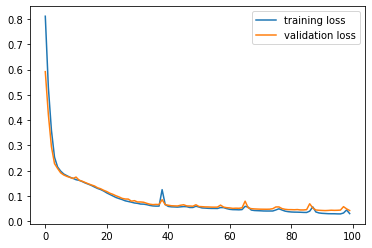

In [14]:
history = pd.DataFrame(results.history)

fig = plt.figure
plt.plot(history['loss'], label="training loss");
plt.plot(history['val_loss'], label="validation loss");

#plt.title('Layers: ' + str(number_layers) + ' - size: ' + str(layers_size))
plt.legend();
plt.show()

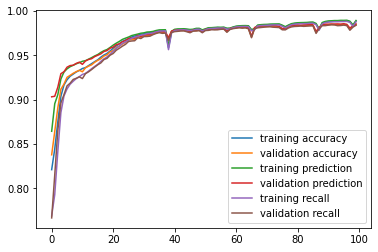

In [15]:
history = pd.DataFrame(results.history)

fig = plt.figure
plt.plot(history['accuracy'], label="training accuracy");
plt.plot(history['val_accuracy'], label="validation accuracy");
plt.plot(history['precision'], label="training prediction");
plt.plot(history['val_precision'], label="validation prediction");
plt.plot(history['recall'], label="training recall");
plt.plot(history['val_recall'], label="validation recall");


#plt.title('Layers: ' + str(number_layers) + ' - size: ' + str(layers_size))
plt.legend();
plt.show()

In [16]:
# Save model
model.save("model_weights/MODEL_weights_chollet_06_train_without_phone")

INFO:tensorflow:Assets written to: model_weights/MODEL_weights_chollet_06_train_without_phone/assets


INFO:tensorflow:Assets written to: model_weights/MODEL_weights_chollet_06_train_without_phone/assets


# Test model

In [17]:
model_eval = model.evaluate([encoder_input_data_test, decoder_input_data_test],decoder_target_data_test)

82/82 [==============================] - 2s 27ms/step - loss: 0.0408 - accuracy: 0.9852 - precision: 0.9859 - recall: 0.9846


In [18]:
print("TEST MODEL\nLoss:", model_eval[0], "\nAccuracy:", model_eval[1], "\nPrecision:", model_eval[2], "\nRecall:", model_eval[3])

TEST MODEL
Loss: 0.0407603457570076 
Accuracy: 0.9851953983306885 
Precision: 0.9859148263931274 
Recall: 0.9846028089523315


# PREDICT

In [19]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 1024  # Latent dimensionality of the encoding space.



In [20]:
model = keras.models.load_model("model_weights/MODEL_weights_chollet_06_train_without_phone")


In [21]:
# define euclidean distance
from math import sqrt
 
# calculate euclidean distance
def euclidean_distance(a, b):
	return sqrt(sum((e1-e2)**2 for e1, e2 in zip(a,b)))


In [22]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.


In [23]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    #target_seq[0, 0, target_token_index["\t"]] = 1.0
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    predicted_tokens=[]
    i=0
    while not stop_condition:
        i=i+1
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=False)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        predicted_tokens.append(sampled_token_index)
        #sampled_char = reverse_target_char_index[sampled_token_index]
        #decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        #if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
        if i == target_max_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    #return decoded_sentence
    return predicted_tokens

# PREDICT MOVE PHONE
### generate encoder_input_data_MOVEPEN, decoder_input_data_MOVEPEN, decoder_target_data_MOVEPEN

In [24]:
audio_features_MOVEPEN = pd.DataFrame(load('features/audio_features_move_phone.npy', allow_pickle=True))
audio_features_onehot_MOVEPEN = keras.utils.to_categorical(audio_features_MOVEPEN, num_classes=None, dtype='float32')

video_features_MOVEPEN = pd.DataFrame(load('features/video_features_move_phone.npy', allow_pickle=True))
video_features_norm_MOVEPEN = normalize(video_features_MOVEPEN)
video_features_norm_100_MOVEPEN = video_features_norm_MOVEPEN * 100
video_features_norm_100_MOVEPEN = video_features_norm_100_MOVEPEN.round()
video_features_onehot_MOVEPEN = keras.utils.to_categorical(video_features_norm_100_MOVEPEN, num_classes=101, dtype='float32')

encoder_input_data_MOVEPEN = video_features_onehot_MOVEPEN
decoder_input_data_MOVEPEN = audio_features_onehot_MOVEPEN
decoder_target_data_MOVEPEN = np.zeros(decoder_input_data_MOVEPEN.shape)
for a in range(decoder_input_data_MOVEPEN.shape[0]):
    for i in range(decoder_input_data_MOVEPEN.shape[1]-1):
        decoder_target_data_MOVEPEN[a][i]=decoder_input_data_MOVEPEN[a][i+1]
    decoder_target_data_MOVEPEN[a][decoder_input_data_MOVEPEN.shape[1]-1] = decoder_input_data_MOVEPEN[a][decoder_input_data_MOVEPEN.shape[1]-1]

    
    
# lengths of vectors
num_encoder_tokens = encoder_input_data.shape[2]
num_decoder_tokens = decoder_input_data.shape[2]
target_max_length = decoder_input_data.shape[1]

In [25]:
entire_test_sequence_length=len(encoder_input_data_MOVEPEN) #2900
n=100
predicted = []
sum_distance = 0
for seq_index in range(n):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data_MOVEPEN[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-SAMPLE N.", seq_index)
    #print("Input sentence:", input_texts[seq_index])
    print("Predicted audio features:", decoded_sentence)
    print("---Target audio features:", list(argmax(decoder_target_data_MOVEPEN[seq_index], axis=1, out=None)))
    predicted.append(decoded_sentence)
    distance = euclidean_distance(decoded_sentence, list(argmax(decoder_target_data_MOVEPEN[seq_index], axis=1, out=None)))
    print("Euclidean distance:", distance)
    sum_distance = sum_distance + distance

mean_distance = sum_distance / n
print ("\n======\nMEAN DISTANCE:", mean_distance)




1/1 [==============================] - 0s 135ms/step
-SAMPLE N. 0
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 11, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 4, 0, 0, 0, 10, 0, 12, 0, 4, 4, 4, 4, 0, 0, 7, 4, 4, 0, 0, 0, 23, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 9, 9, 5, 5, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 0, 17, 0, 0, 0, 8, 0, 25, 0, 5, 0, 4, 4, 0, 6, 11, 5, 4, 4, 0, 23, 11, 0, 0, 8, 8, 0, 0, 9, 5, 5, 4, 4, 4, 6, 6, 0, 8, 0, 4, 4, 4, 6, 11, 5, 4, 4, 0, 15, 0, 0, 0, 0, 5, 0, 20, 0, 0, 0, 6, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 8
Predicted audio features: [6, 11, 0, 10, 12, 0, 4, 4, 0, 10, 0, 12, 4, 4, 4, 7, 4, 4, 0, 20, 0, 0, 0, 0, 0, 0, 0, 7, 13, 0, 0, 17, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 17, 0, 0, 0, 0, 8, 0, 25, 0, 5, 0, 4, 4, 6, 6, 11, 5, 4, 4, 0, 23, 11, 0, 0, 0, 0, 8, 0, 0, 0, 9, 0, 5, 0, 4, 4, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 18, 0, 0, 9, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 16
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 11, 0, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 0, 0, 0, 0, 10, 12, 12, 0, 4, 4, 4, 0, 0, 0, 7, 0, 4, 0, 0, 0, 23, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 9, 0, 5, 5, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 15, 0, 0, 0, 0, 8, 0, 12, 0, 5, 0, 4, 4, 6, 11, 5, 0, 4, 0, 23, 11, 0, 0, 0, 8, 0, 0, 9, 5, 0, 4, 4, 6, 0, 8, 4, 4, 4, 6, 11, 5, 4, 4, 13, 13, 0, 0, 0, 10, 21, 21, 11, 6, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1/1 [==============================] - 0s 13ms/step
-SAMPLE N. 24
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 10, 0, 12, 0, 0, 4, 4, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 4, 0, 0, 7, 4, 4, 0, 0, 23, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 7, 18, 0, 0, 0, 9, 9, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [13, 13, 0, 8, 16, 0, 0, 0, 0, 6, 0, 0, 0, 7, 0, 26, 0, 5, 4, 4, 0, 6, 11, 5, 4, 4, 23, 11, 11, 0, 0, 0, 0, 8, 0, 0, 9, 0, 5, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 32
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 10, 12, 12, 0, 4, 0, 0, 10, 12, 12, 4, 4, 7, 4, 0, 23, 11, 11, 0, 0, 8, 0, 0, 9, 5, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 17, 0, 0, 0, 0, 8, 0, 25, 0, 5, 0, 0, 4, 4, 6, 6, 11, 5, 4, 4, 0, 23, 11, 0, 0, 0, 8, 0, 0, 0, 9, 5, 5, 4, 4, 0, 0, 0, 0, 0, 16, 0, 23, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 40
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 10, 0, 12, 0, 4, 4, 0, 10, 12, 12, 4, 4, 7, 4, 0, 23, 11, 11, 0, 0, 8, 0, 0, 9, 5, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 17, 0, 0, 8, 0, 25, 0, 5, 0, 4, 4, 4, 6, 11, 5, 4, 4, 0, 23, 11, 11, 0, 0, 8, 0, 0, 9, 9, 5, 0, 4, 4, 0, 6, 0, 8, 0, 4, 4, 4, 6, 11, 5, 4, 4, 0, 15, 0, 0, 0, 0, 0, 5, 0, 20, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1/1 [==============================] - 0s 13ms/step
-SAMPLE N. 48
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 4, 0, 0, 0, 0, 10, 0, 12, 0, 4, 4, 4, 4, 0, 0, 7, 4, 0, 0, 0, 23, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 9, 0, 5, 5, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 8, 0, 25, 5, 5, 4, 4, 4, 0, 6, 11, 5, 4, 4, 0, 23, 11, 0, 0, 0, 8, 8, 0, 0, 9, 0, 5, 0, 4, 4, 14, 14, 0, 0, 0, 0, 0, 8, 8, 18, 0, 9, 9, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 56
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 10, 0, 12, 0, 0, 4, 4, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 4, 0, 0, 7, 4, 4, 0, 0, 23, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 7, 18, 0, 0, 0, 9, 9, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 17, 0, 0, 0, 0, 8, 0, 25, 0, 5, 0, 4, 4, 6, 11, 5, 4, 4, 4, 0, 23, 11, 0, 0, 0, 8, 0, 0, 9, 0, 5, 0, 4, 4, 6, 6, 8, 4, 4, 4, 6, 11, 5, 4, 4, 4, 13, 13, 0, 0, 0, 10, 10, 21, 0, 11, 0, 6, 6, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 64
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 10, 12, 12, 0, 4, 0, 0, 10, 12, 12, 4, 4, 7, 4, 0, 23, 11, 11, 0, 0, 8, 0, 0, 9, 5, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 13, 13, 0, 0, 8, 0, 0, 0, 6, 0, 0, 0, 7, 0, 0, 6, 5, 0, 4, 4, 6, 11, 5, 5, 4, 4, 23, 11, 11, 0, 0, 0, 0, 8, 0, 0, 0, 9, 5, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1/1 [==============================] - 0s 14ms/step
-SAMPLE N. 72
Predicted audio features: [0, 0, 10, 12, 0, 4, 4, 0, 10, 12, 12, 4, 4, 7, 4, 4, 20, 0, 0, 0, 0, 7, 13, 0, 17, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [8, 0, 0, 8, 0, 25, 0, 0, 0, 4, 6, 11, 5, 4, 4, 23, 11, 0, 0, 8, 0, 0, 0, 0, 9, 0, 0, 4, 0, 0, 16, 0, 23, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 80
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 0, 0, 0, 0, 10, 0, 12, 12, 0, 4, 4, 4, 4, 4, 7, 4, 4, 0, 0, 12, 12, 0, 0, 0, 0, 0, 23, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 8, 0, 9, 9, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 17, 0, 0, 0, 8, 0, 25, 0, 5, 0, 0, 4, 4, 6, 6, 11, 5, 4, 4, 0, 23, 11, 0, 0, 0, 0, 8, 0, 0, 9, 0, 5, 0, 4, 4, 0, 0, 0, 6, 6, 0, 8, 0, 0, 4, 4, 6, 11, 5, 4, 4, 0, 15, 0, 0, 0, 0, 0, 5, 20, 0, 0, 0, 6, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1/1 [==============================] - 0s 12ms/step
-SAMPLE N. 88
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 0, 0, 0, 0, 10, 0, 12, 12, 0, 4, 4, 4, 4, 4, 7, 4, 4, 0, 0, 12, 12, 0, 0, 0, 0, 0, 23, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 8, 0, 9, 9, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 0, 0, 17, 0, 0, 0, 8, 25, 25, 5, 0, 14, 4, 4, 6, 11, 5, 4, 4, 4, 23, 11, 0, 0, 8, 0, 0, 0, 9, 5, 0, 4, 4, 0, 14, 0, 0, 0, 0, 0, 8, 8, 18, 0, 9, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1/1 [==============================] - 0s 13ms/step
-SAMPLE N. 96
Predicted audio features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 11, 0, 0, 0, 0, 10, 0, 12, 0, 0, 4, 4, 4, 0, 0, 0, 0, 10, 12, 12, 0, 4, 4, 4, 4, 0, 0, 7, 4, 4, 0, 0, 23, 11, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 9, 0, 5, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---Target audio features: [0, 0, 0, 17, 17, 0, 0, 0, 0, 8, 0, 25, 0, 5, 0, 0, 4, 4, 0, 6, 11, 5, 4, 4, 0, 23, 11, 11, 0, 0, 0, 8, 0, 0, 0, 9, 5, 0, 4, 4, 0, 6, 0, 8, 0, 4, 4, 6, 11, 5, 4, 4, 0, 13, 0, 0, 0, 10, 0, 21, 11, 11, 6, 6, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [26]:
print ("MEAN DISTANCE:", mean_distance)


MEAN DISTANCE: 59.06406688028469


In [27]:
save('predictions/PREDICTED_MODEL_CHOLLET_06_move_phone_0-100.npy', pd.DataFrame(predicted))

# Test model

In [28]:
model_eval = model.evaluate([encoder_input_data_MOVEPEN, decoder_input_data_MOVEPEN],decoder_target_data_MOVEPEN)

46/46 [==============================] - 2s 27ms/step - loss: 0.7294 - accuracy: 0.8852 - precision: 0.8874 - recall: 0.8838


In [29]:
print("TEST MODEL\nLoss:", model_eval[0], "\nAccuracy:", model_eval[1], "\nPrecision:", model_eval[2], "\nRecall:", model_eval[3])

TEST MODEL
Loss: 0.7293970584869385 
Accuracy: 0.8852046132087708 
Precision: 0.8874162435531616 
Recall: 0.8838298916816711
